# Sentiment Analysis Pipeline for Reviews

1. Normalize Reviews
2. Preprocess Reviews for Sentiment Analysis
3. Exploratory Data Analysis
4. Sentiment Analysis
5. Conclusion

## 1. Normalize Reviews
1.	Removing duplicated rows
2.	Normalize date to year
3.	Normalize ratings to 10

In [1]:
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta

def normalize_reviews(filepath):
  '''
  1. Drop duplicated rows
  2. Normalize dates to only the year
  3. Normalize ratings to 10
  '''
  
  df = pd.read_excel(filepath)
  
  # Drop duplicated rows
  df.drop_duplicates(keep='first', inplace=True)
  
  '''
  1. Normalize dates to only year
    - fix_date_week | fix_date_month | fix_date_year
      - Takes current date and minus off respective week, month or year
  '''
  
  def fix_date_week(week):
    date = datetime.datetime.now()
    date = date.date()
    newdate = date - relativedelta(weeks=week)
    return newdate
  
  def fix_date_month(month):
    date = datetime.datetime.now()
    date = date.date()
    newdate = date - relativedelta(months=month)
    return newdate
  
  def fix_date_year(year):
    date = datetime.datetime.now()
    date = date.date()
    newdate = date - relativedelta(years=year)
    return newdate
  
  # Replace date strings with proper year
  # Only up to 10 years
  replace_date = {'seminggu lalu': fix_date_week(1),
                  '2 minggu lalu': fix_date_week(2),
                  '3 minggu lalu': fix_date_week(3),
                  'sebulan lalu': fix_date_month(1),
                  '2 bulan lalu': fix_date_month(2),
                  '3 bulan lalu': fix_date_month(3),
                  '4 bulan lalu': fix_date_month(4),
                  '5 bulan lalu': fix_date_month(5),
                  '6 bulan lalu': fix_date_month(6),
                  '7 bulan lalu': fix_date_month(7),
                  '8 bulan lalu': fix_date_month(8),
                  '9 bulan lalu': fix_date_month(9),
                  '10 bulan lalu': fix_date_month(10),
                  '11 bulan lalu': fix_date_month(11),
                  'setahun lalu': fix_date_year(1),
                  '2 tahun lalu': fix_date_year(2),
                  '3 tahun lalu': fix_date_year(3),
                  '4 tahun lalu': fix_date_year(4),
                  '5 tahun lalu': fix_date_year(5),
                  '6 tahun lalu': fix_date_year(6),
                  '7 tahun lalu': fix_date_year(7),
                  '8 tahun lalu': fix_date_year(8),
                  '9 tahun lalu': fix_date_year(9),
                  '10 tahun lalu': fix_date_year(10),}
  
  # Split dataframe with proper datetime format
  df1 = df[df['date'].apply(lambda x: isinstance(x, datetime.date))]
  # Split dataframe with date strings
  df2 = df[df['date'].apply(lambda x: not isinstance(x, datetime.date))]
  # Replace date strings with proper year
  df2 = df2.replace({"date": replace_date})
  
  # Only extract year
  df1['date'] = pd.DatetimeIndex(df1['date']).year
  df2['date'] = pd.DatetimeIndex(df2['date']).year
  
  # Concatenate fixed year
  df = pd.concat([df1, df2], ignore_index=True)
  
  #2. Normalize ratings to 10
  
  # Replace Klook ratings with 'Baik' to 8 and 'Sangat Direkomendasikan' to 10
  replace_rating = {'Baik': 8,
                  'Sangat Direkomendasikan': 10}
  df = df.replace({'rating': replace_rating})
  
  # Mask for TripAdvisor ratings
  mask = (df['source'] == 'tripadvisor')
  # Retrieve index 0 string of rating and multiply by 2
  df.loc[mask, 'rating'] = (df.loc[mask, 'rating'].str[0].astype(int))*2
  
  # Mask for Google Review ratings
  mask2 = (df['source'] == 'google_reviews')
  # Retrieve index 0 string of rating and multiply by 2
  df.loc[mask2, 'rating'] = (df.loc[mask2, 'rating'].str[14].astype(int))*2
  
  return df

In [2]:
df = normalize_reviews("../preprocess_review/raw_data/uss_master_copy.xlsx")
df.head()

C:\Users\Luqman\AppData\Local\Temp\ipykernel_16828\1373090205.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date'] = pd.DatetimeIndex(df1['date']).year


,user,date,rating,review,page_url,date_scraped,source,attraction
0,mpocasino,2020,10,Universal Studio Singapore yang berada di Pula...,https://www.tripadvisor.co.id/Attraction_Revie...,4/26/2022,tripadvisor,uss
1,Rudy K,2019,10,cukup beruntung hanya membeli tiket biasa dapa...,https://www.tripadvisor.co.id/Attraction_Revie...,4/26/2022,tripadvisor,uss
2,Alma Jaya,2019,10,Tempat liburan keluarga yang sangat menarik un...,https://www.tripadvisor.co.id/Attraction_Revie...,4/26/2022,tripadvisor,uss
3,Sri Pratiwi,2020,10,Beli tiketnya via OTA dan kebetulan sudah prin...,https://www.tripadvisor.co.id/Attraction_Revie...,4/26/2022,tripadvisor,uss
4,Didik K,2020,10,"Jalan jalan bareng si kecil, emang menyenangka...",https://www.tripadvisor.co.id/Attraction_Revie...,4/26/2022,tripadvisor,uss


In [3]:
# For export use later
attraction = df['attraction'][0]

## 2. Preprocessing for Sentiment Analysis

  - Lowercasing reviews
  - Remove punctuation, symbols and emojis
  - Remove empty rows
  - Fix slang words
  - Summarize reviews with more than 1536 characters
  - Stemming
  - Remove stop words

In [4]:
# Drop irrelevant columns
df.drop(['user','page_url','date_scraped','attraction'], axis=1, inplace=True)
df.head()

,date,rating,review,source
0,2020,10,Universal Studio Singapore yang berada di Pula...,tripadvisor
1,2019,10,cukup beruntung hanya membeli tiket biasa dapa...,tripadvisor
2,2019,10,Tempat liburan keluarga yang sangat menarik un...,tripadvisor
3,2020,10,Beli tiketnya via OTA dan kebetulan sudah prin...,tripadvisor
4,2020,10,"Jalan jalan bareng si kecil, emang menyenangka...",tripadvisor


In [7]:
import pandas as pd
import ast
import re

import spacy
id_nlp = spacy.blank('id')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

from transformers import pipeline

summary_model = pipeline("summarization",
                model="cahya/t5-base-indonesian-summarization-cased",
                tokenizer="cahya/t5-base-indonesian-summarization-cased")

In [10]:
def preprocess_sentiment(dataframe):
  '''
  Preprocessing
  - Lowercasing reviews
  - Remove punctuation, symbols and emojis
  - Remove empty rows
  - Fix slang words
  - Summarize reviews with more than 1536 characters
  - Stemming
  - Remove stop words
  '''
  file = open("../resources/bahasa_indonesia_slangwords.txt", "r")
  contents = file.read()
  slangwords = ast.literal_eval(contents)
  
  def tokenize_id(text):
    text_list = [token.text for i, token in enumerate(id_nlp(text))]
    return text_list
  
  def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
  
  df['new_reviews'] = df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
  df['new_reviews'] = df['new_reviews'].str.replace('[^\w\s]','')
  df['new_reviews'] = df['new_reviews'].apply(lambda x: remove_emoji(x))
  
  # Remove empty rows
  df[df['new_reviews'].str.strip().astype(bool)]
  
  # Fix slang words
  df['new_reviews'] = df['new_reviews'].apply(lambda x: " ".join(slangwords.get(word, word) for word in tokenize_id(x)))
  
  # Summarize reviews
  # Reviews more than 1536 characters (Average indonesian word has 3 characters times 512 which is max sentiment tensor input)
  mask = (df['new_reviews'].str.len() >= 1536)
  df.loc[mask, 'new_reviews'] = df.loc[mask, 'new_reviews'].apply(lambda x: summary_model(x)[0]['summary_text']).str.replace('[^\w\s]','')
  
  # Stemming
  df['new_reviews'] = df['new_reviews'].apply(lambda x: stemmer.stem(x))

In [11]:
preprocess_sentiment(df)

C:\Users\Luqman\AppData\Local\Temp\ipykernel_16828\3983724304.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df['new_reviews'] = df['new_reviews'].str.replace('[^\w\s]','')
C:\Users\Luqman\AppData\Local\Temp\ipykernel_16828\3983724304.py:41: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[mask, 'new_reviews'] = df.loc[mask, 'new_reviews'].apply(lambda x: summary_model(x)[0]['summary_text']).str.replace('[^\w\s]','')


In [12]:
df

,date,rating,review,source,new_reviews
0,2020,10,Universal Studio Singapore yang berada di Pula...,tripadvisor,universal studio singapore yang ada di pulau s...
1,2019,10,cukup beruntung hanya membeli tiket biasa dapa...,tripadvisor,cukup untung hanya beli tiket biasa dapat ikut...
2,2019,10,Tempat liburan keluarga yang sangat menarik un...,tripadvisor,tempat libur keluarga yang sangat tarik untuk ...
3,2020,10,Beli tiketnya via OTA dan kebetulan sudah prin...,tripadvisor,beli tiket via ota dan betul sudah print dari ...
4,2020,10,"Jalan jalan bareng si kecil, emang menyenangka...",tripadvisor,jalan jalan bareng si kecil emang senang dan d...
...,...,...,...,...,...
3123,2020,10,Sukses selalu Singapura,google_reviews,sukses selalu singapura
3124,2020,10,Tempat e asyik,google_reviews,tempat e asyik
3125,2016,8,Keren bgt...♥Q sdh pernh dtng ke sana,google_reviews,keren bgtq sdh pernh dtng ke sana
3126,2019,10,Bagus,google_reviews,bagus


## Remove Stop Words

In [14]:
nlp = spacy.load("en_core_web_lg")

eng_stopwords = set(line.strip() for line in open('../resources/stop_words_english.txt', encoding='utf-8'))
id_stopwords = set(line.strip() for line in open('../resources/stop_words_bahasaindonesia.txt', encoding='utf-8'))
new_stopwords = eng_stopwords.union(id_stopwords)

# Add new set of stopwords into spacy stopword list
nlp.Defaults.stop_words |= new_stopwords

In [15]:
df['new_reviews'] = df['new_reviews'].apply(lambda text: 
                                          " ".join(token.text for token in nlp(text) 
                                                   if not token.is_stop))

In [16]:
df = df[['date', 'source', 'review', 'new_reviews', 'rating']]

In [19]:
# Remove empty rows in case review only contain stop words
df = df[df['new_reviews'].str.strip().astype(bool)]
df

,date,source,review,new_reviews,rating
0,2020,tripadvisor,Universal Studio Singapore yang berada di Pula...,universal studio singapore pulau sentosa singa...,10
1,2019,tripadvisor,cukup beruntung hanya membeli tiket biasa dapa...,untung beli tiket hampir aktrasi pagipagi cuac...,10
2,2019,tripadvisor,Tempat liburan keluarga yang sangat menarik un...,libur keluarga tarik kunjung sarana rekreasi e...,10
3,2020,tripadvisor,Beli tiketnya via OTA dan kebetulan sudah prin...,beli tiket ota print rumah uss tugas barcodeny...,10
4,2020,tripadvisor,"Jalan jalan bareng si kecil, emang menyenangka...",jalan jalan bareng si kecil senang bagus senan...,10
...,...,...,...,...,...
3123,2020,google_reviews,Sukses selalu Singapura,sukses singapura,10
3124,2020,google_reviews,Tempat e asyik,e asyik,10
3125,2016,google_reviews,Keren bgt...♥Q sdh pernh dtng ke sana,keren bgtq sdh pernh dtng,8
3126,2019,google_reviews,Bagus,bagus,10


## Sentiment Analysis

In [20]:
from transformers import pipeline
import sentencepiece
from tqdm.notebook import tqdm
tqdm.pandas()

sentiment_model = pipeline(
    "sentiment-analysis",
    model="ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa",
    tokenizer="ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa"
)

def get_sentiment(text):
    prediction = sentiment_model(text)[0]['label']
    return prediction

In [21]:
df['sentiment'] = df['new_reviews'].progress_apply(get_sentiment)

  0%|          | 0/3104 [00:00<?, ?it/s]

C:\Users\Luqman\AppData\Local\Temp\ipykernel_16828\2280052479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['new_reviews'].progress_apply(get_sentiment)


In [22]:
df = df[['date', 'source', 'review', 'new_reviews', 'rating', 'sentiment']]
df

,date,source,review,new_reviews,rating,sentiment
0,2020,tripadvisor,Universal Studio Singapore yang berada di Pula...,universal studio singapore pulau sentosa singa...,10,Neutral
1,2019,tripadvisor,cukup beruntung hanya membeli tiket biasa dapa...,untung beli tiket hampir aktrasi pagipagi cuac...,10,Positive
2,2019,tripadvisor,Tempat liburan keluarga yang sangat menarik un...,libur keluarga tarik kunjung sarana rekreasi e...,10,Neutral
3,2020,tripadvisor,Beli tiketnya via OTA dan kebetulan sudah prin...,beli tiket ota print rumah uss tugas barcodeny...,10,Neutral
4,2020,tripadvisor,"Jalan jalan bareng si kecil, emang menyenangka...",jalan jalan bareng si kecil senang bagus senan...,10,Positive
...,...,...,...,...,...,...
3123,2020,google_reviews,Sukses selalu Singapura,sukses singapura,10,Positive
3124,2020,google_reviews,Tempat e asyik,e asyik,10,Positive
3125,2016,google_reviews,Keren bgt...♥Q sdh pernh dtng ke sana,keren bgtq sdh pernh dtng,8,Positive
3126,2019,google_reviews,Bagus,bagus,10,Positive


In [23]:
# Add Length and Word Count 
df['review_len'] = df['new_reviews'].astype(str).apply(len)
df['word_count'] = df['new_reviews'].apply(lambda x: len(str(x).split()))

In [26]:
# Export data
df.to_excel(f'{attraction}_sentiment.xlsx', index=False)
df.to_csv(f'{attraction}_sentiment.csv', index=False)

## Analysis & Visualization

- Review Rating Distribution
- Review Length Distribution
- Review Word Count Distribution
- Ratings vs. Sentiment
- Sentiment Share Overall
- Word Cloud
- Top Word Frequency
- Top 15 Words For Positive Sentiment
- Top 15 Words For Neutral Sentiment
- Top 15 Words For Negative Sentiment

**TODO**
- Review length based on ratings
- Review length based on sentiment

In [27]:
df.groupby(['rating'])['new_reviews'].count()

rating
2        3
4       11
5       14
6      112
8      779
9      331
10    1854
Name: new_reviews, dtype: int64

### The distribution of ratings

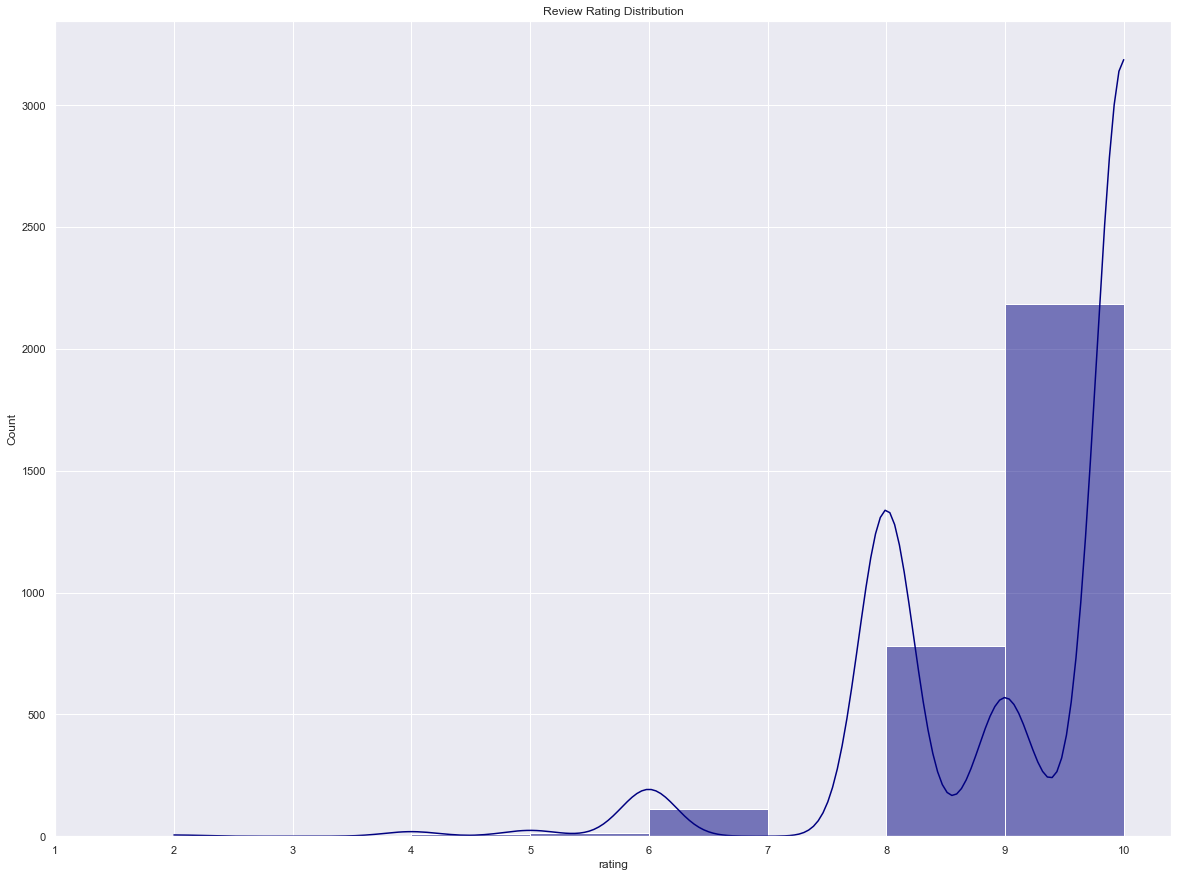

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

ratings_dist = sns.histplot(
    data=df,
    x="rating",
    color='navy',
    bins=10,
    binwidth=1,
    kde=True
)

plt.xticks(range(1,11))
plt.title("Review Rating Distribution")
sns.set_theme(rc={'figure.figsize':(20,15)},
              style="darkgrid")

### The distribution of review text lengths

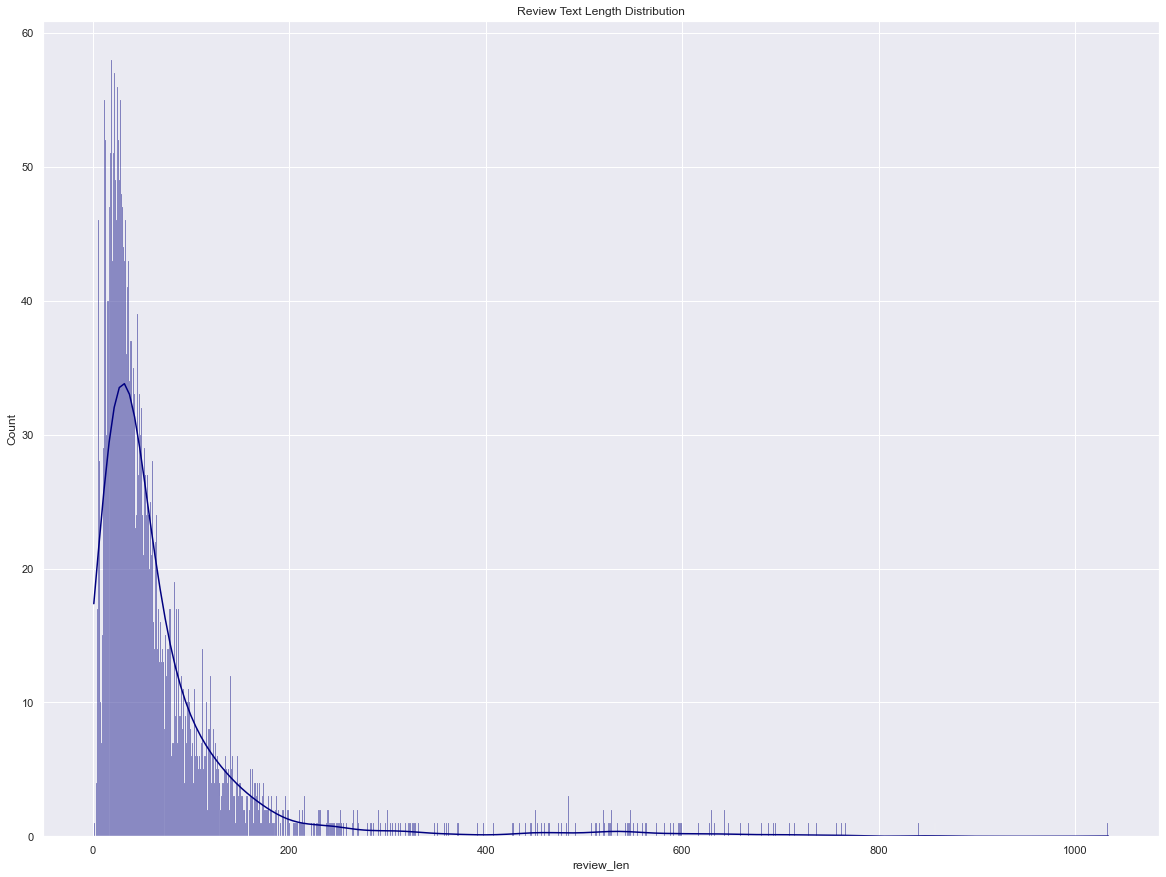

In [30]:
review_length_dist = sns.histplot(
    data=df,
    x="review_len",
    color='navy',
    bins=10,
    binwidth=1,
    kde=True
)

plt.title("Review Text Length Distribution")
sns.set_theme(rc={'figure.figsize':(20,15)},
              style="darkgrid")

### The distribution of review word count

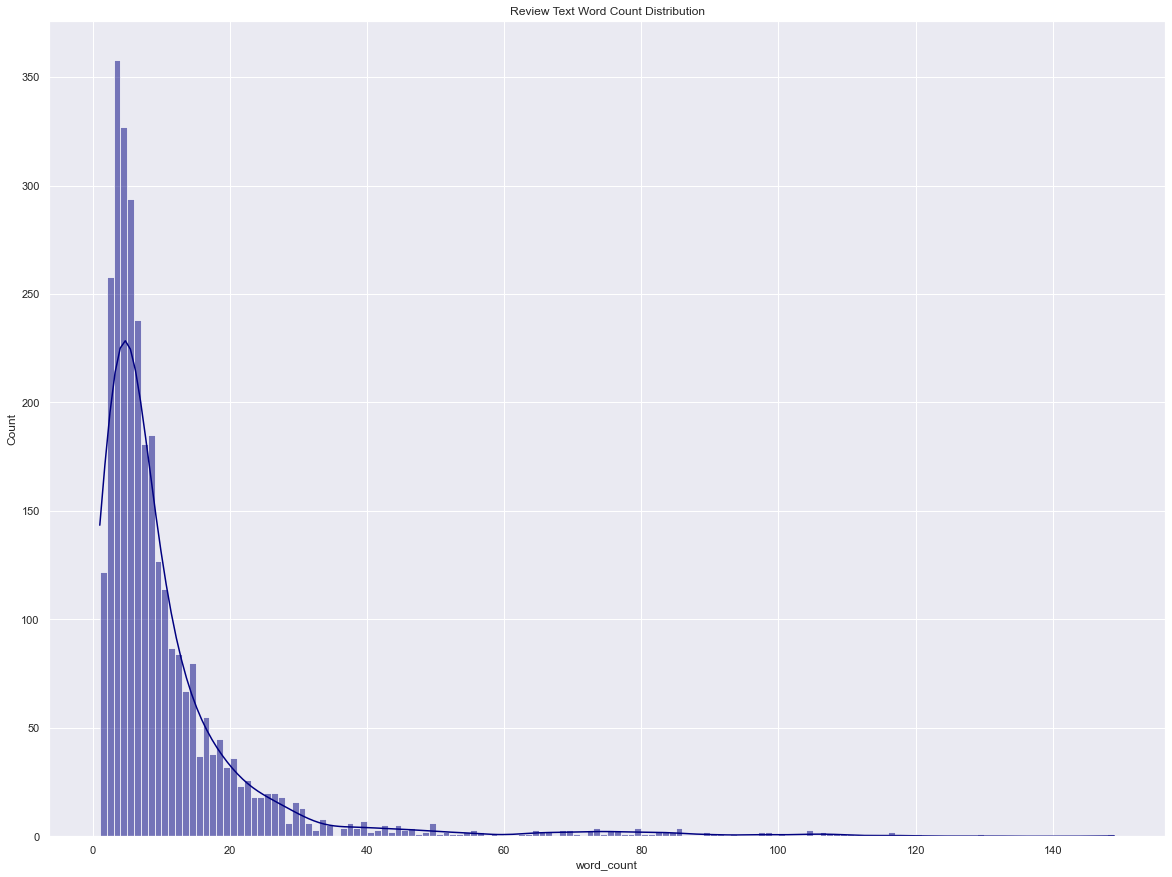

In [31]:
review_length_dist = sns.histplot(
    data=df,
    x="word_count",
    color='navy',
    bins=10,
    binwidth=1,
    kde=True
)

plt.title("Review Text Word Count Distribution")
sns.set_theme(rc={'figure.figsize':(20,15)},
              style="darkgrid")

### Ratings vs. Sentiment

In [32]:
df.groupby(['rating','sentiment'])['new_reviews'].count()

rating  sentiment
2       Neutral         2
        Positive        1
4       Negative        2
        Neutral         3
        Positive        6
5       Negative        7
        Neutral         6
        Positive        1
6       Negative       29
        Neutral        38
        Positive       45
8       Negative       65
        Neutral       194
        Positive      520
9       Negative       22
        Neutral        73
        Positive      236
10      Negative      143
        Neutral       403
        Positive     1308
Name: new_reviews, dtype: int64

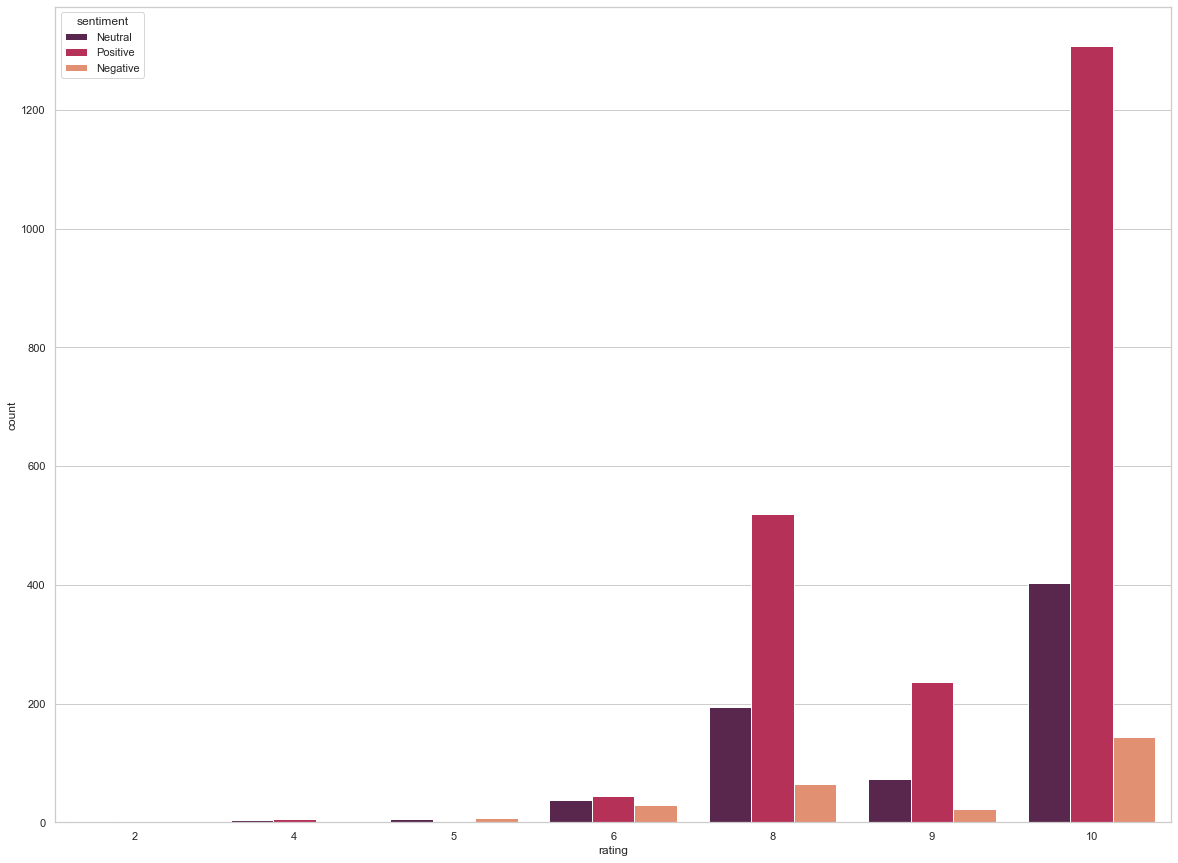

In [33]:
sns.set_theme(style="whitegrid")

rating_vs_sentiment = sns.countplot(
    data=df,
    x="rating", hue="sentiment", palette="rocket",
)
sns.set_theme(rc={'figure.figsize':(20,15)})

### Sentiment Share for USS Attraction

<AxesSubplot:ylabel='new_reviews'>

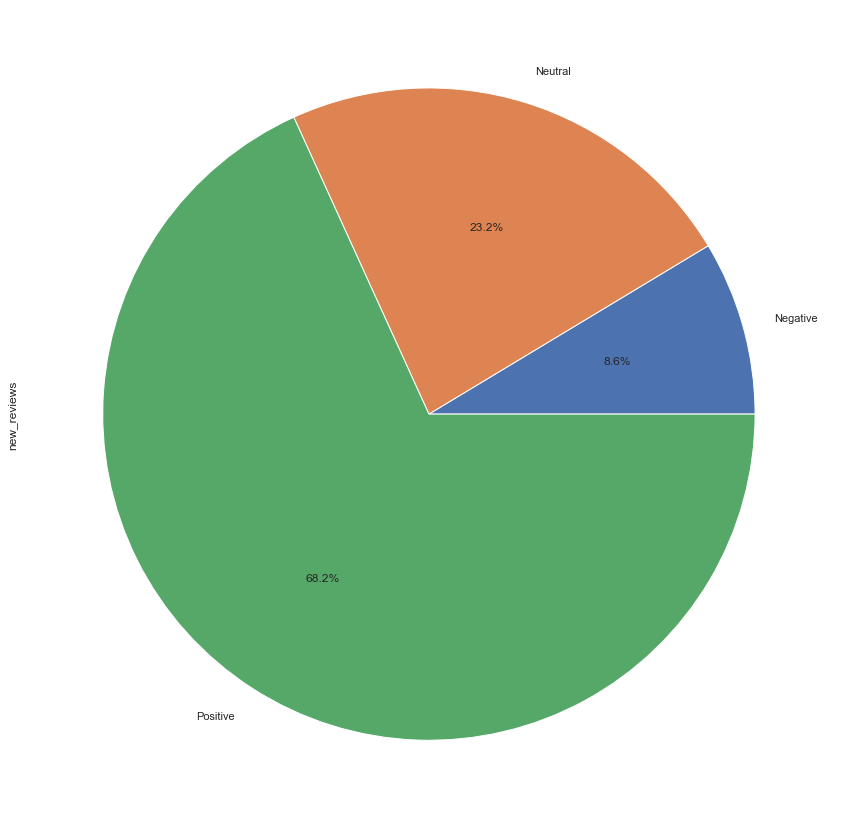

In [35]:
sentiment_share_overall = df.groupby('sentiment')['new_reviews'].count()
sentiment_share_overall.plot.pie(autopct="%.1f%%")

### Word Cloud

In [122]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

img_mask = np.array(Image.open('sentosa.jpg'))

def show_wordcloud(data, output = None):
    '''
    Generate word cloud with color function
    output = Figure output name
    '''
    def one_color_func(word=None, font_size=None, position=None, 
                   orientation=None, font_path=None, random_state=None):
        h = 36 # 0 - 360
        s = 100 # 0 - 100
        l = 50
        # l = random_state.randint(30, 70) # 0 - 100
        return "hsl({}, {}%, {}%)".format(h, s, l)

    wordcloud = WordCloud(
        width=img_mask.shape[1], 
        height=img_mask.shape[0],
        colormap='Pastel1',
        mask=img_mask,
        color_func=one_color_func,
        background_color='white'
    ).generate(str(data))

    fig = plt.figure(1, figsize=(16, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.savefig(f'figures/{attraction}_{output}_wordcloud.png', bbox_inches='tight')
    plt.show()

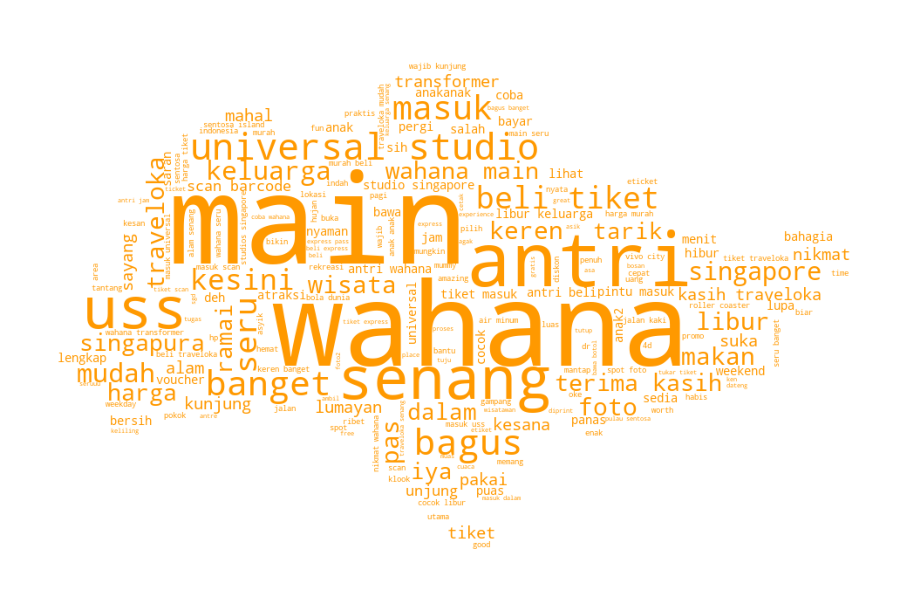

In [123]:
text = " ".join(i for i in df.new_reviews)
show_wordcloud(text, "overall")

### Top 15 Words Overall

In [127]:
top_words = WordCloud().process_text(text)
top_words = pd.DataFrame(top_words.items(), columns=['word', 'frequency']).sort_values(by=['frequency'], ascending=False)
top_words.to_excel(f"{attraction}_topwords.xlsx", sheet_name='overall', index=False)
top_words.head(15)

,word,frequency
6,main,595
5,wahana,511
77,antri,486
45,senang,424
29,uss,401
3785,universal studio,332
46,bagus,318
66,banget,304
33,masuk,269
62,seru,243


### Top Words in Positive Sentiment

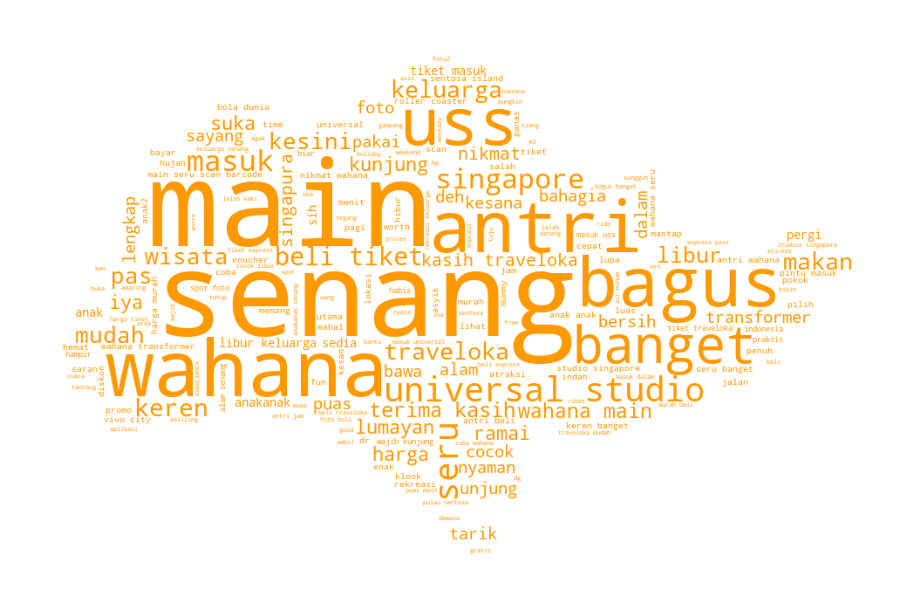

In [125]:
mask = (df['sentiment'] == 'Positive')
pos_df = df[mask]
pos_text = " ".join(i for i in pos_df.new_reviews)
show_wordcloud(pos_text, "positive")

In [128]:
# For new sheet on same excel file
import os

def save_excel_sheet(df, filepath, sheetname, index=False):
    # Create file if it does not exist
    if not os.path.exists(filepath):
        df.to_excel(filepath, sheet_name=sheetname, index=index)

    # Otherwise, add a sheet. Overwrite if there exists one with the same name.
    else:
        with pd.ExcelWriter(filepath, engine='openpyxl', if_sheet_exists='replace', mode='a') as writer:
            df.to_excel(writer, sheet_name=sheetname, index=index)

In [129]:
pos_wordcount = WordCloud().process_text(pos_text)
pos_wordcount = pd.DataFrame(pos_wordcount.items(), columns=['word', 'frequency']).sort_values(by=['frequency'], ascending=False)
save_excel_sheet(pos_wordcount, f"{attraction}_topwords.xlsx", 'positive')
pos_wordcount.head(15)

,word,frequency
25,main,442
12,senang,437
24,wahana,401
162,antri,328
13,bagus,299
248,uss,276
39,banget,262
2925,universal studio,234
35,seru,226
98,masuk,165


### Top Words in Neutral Sentiment

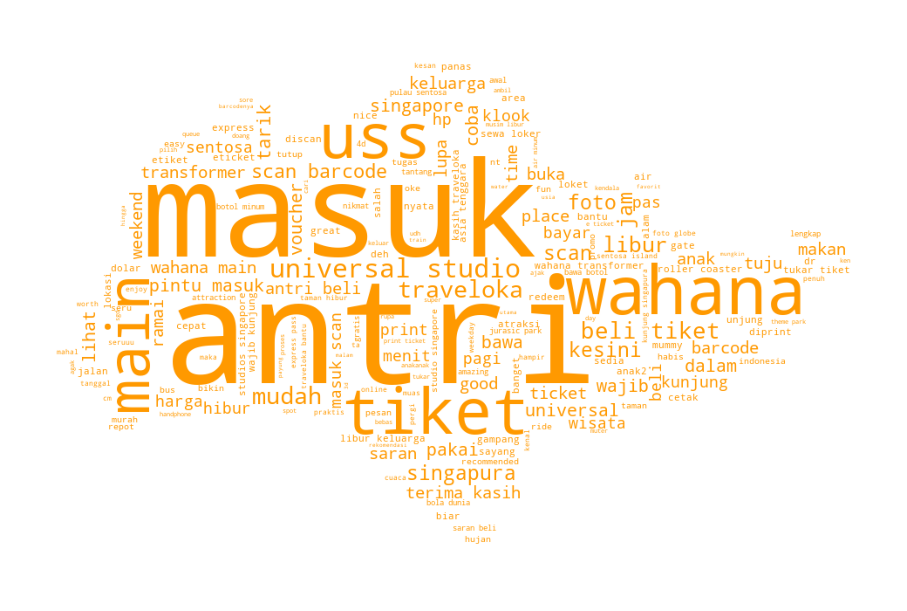

In [130]:
mask = (df['sentiment'] == 'Neutral')
neu_df = df[mask]
neu_text = " ".join(i for i in neu_df.new_reviews)
show_wordcloud(neu_text, "neutral")

In [131]:
neu_wordcount = WordCloud().process_text(neu_text)
neu_wordcount = pd.DataFrame(neu_wordcount.items(), columns=['word', 'frequency']).sort_values(by=['frequency'], ascending=False)
save_excel_sheet(neu_wordcount, f"{attraction}_topwords.xlsx", 'neutral')
neu_wordcount.head(15)

,word,frequency
44,antri,191
24,masuk,161
5,wahana,128
16,tiket,112
20,uss,109
6,main,97
1490,universal studio,83
397,traveloka,68
101,mudah,68
1497,beli tiket,63


### Top Words in Negative Sentiment

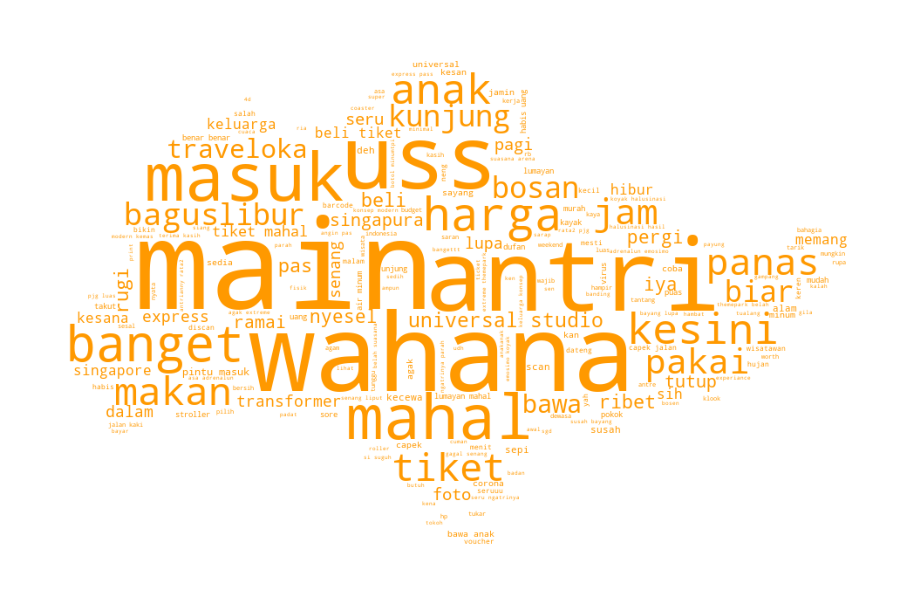

In [132]:
mask = (df['sentiment'] == 'Negative')
neg_df = df[mask]
neg_text = " ".join(i for i in neg_df.new_reviews)
show_wordcloud(neg_text, "negative")

In [133]:
neg_wordcount = WordCloud().process_text(neg_text)
neg_wordcount = pd.DataFrame(neg_wordcount.items(), columns=['word', 'frequency']).sort_values(by=['frequency'], ascending=False)
save_excel_sheet(neu_wordcount, f"{attraction}_topwords.xlsx", 'negative')
neg_wordcount.head(15)

,word,frequency
74,main,71
73,wahana,65
12,antri,54
46,uss,41
6,masuk,40
66,mahal,36
57,banget,35
65,harga,30
2,kesini,26
0,anak,25


In [16]:
# TODO: Look into plotly + dash for deploying visualisation